In [1]:
import sys
sys.path.append('../../../')
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gmapy.data_management.object_utils import (
    load_objects, save_objects
)
from gmapy.mcmc_inference import compute_effective_sample_size
from gmapy.mappings.tf.compound_map_tf import CompoundMap
from gmapy.mappings.tf.restricted_map import RestrictedMap
from gmapy.gmap import run_gmap_simplified
from gmapy.legacy.legacy_gmap import run_gmap

2023-10-15 14:07:35.065420: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 14:07:35.066595: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 14:07:35.093631: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 14:07:35.094526: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 14:07:35.571469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
#thisdir = '/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/tensorflow/example-005-std2017/output/'
#thisdir = '/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/tensorflow/example-005/output/'
#gma_dbfile='../../../tests/testdata/data_and_sacs.json'
#gma_dbtype='json'

#thisdir = '/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/tensorflow/example-005-lisowski_abs/output/'
#gma_dbfile='../../../tests/testdata/data_and_sacs.json'
#gma_dbtype='json'

#thisdir = '/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/tensorflow/example-005/output_backup/'
#gma_dbfile='../../../tests/testdata/data_and_sacs.json'
#gma_dbtype='json'

thisdir = '/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/tensorflow/example-005-std2017/output/'
gma_dbfile='../../../legacy-tests/test_002/input/data.gma'
gma_dbtype='legacy'

# load the priortable
priortable, exptable, expcov, is_adj = load_objects(thisdir + '01_model_preparation_output.pkl', 'priortable', 'exptable', 'expcov', 'is_adj')
red_priortable = priortable.loc[is_adj].reset_index(drop=True)

tmp = red_priortable[['DESCR', 'REAC']].drop_duplicates()
tmp = tmp[~tmp.DESCR.isna()]
mtdic = {x: y for x, y in zip(tmp.DESCR, tmp.REAC)}

reacs = exptable.REAC.str.replace('MT:2', 'MT:1')
reacs = reacs.str.replace('MT:4', 'MT:3')
reacs = reacs.str.replace('MT:8', 'MT:5')
reacs = reacs.str.replace('MT:9', 'MT:7')
exptable['ABSREAC'] = reacs

In [3]:
# only works for MCMC with USU components
# num_covpars, = load_objects(thisdir + '01_model_preparation_output.pkl', 'num_covpars')

In [4]:
# 1) load all the standard data from the standards 2017
#    to create a pseudo-experimental dataset
descr_list = []
outdt_list = []

tmp = pd.read_csv('std17-003_Li_006.txt', comment='#', index_col=None, sep=r'\s+')
descr = '6Li(n,a)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1000', 'REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp.CS.to_numpy(), 'UNC': tmp.DCS.to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('std17-005_B_010.txt', comment='#', index_col=None, sep=r'\s+')
descr = '10B(n,a1)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1001','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp.CS.to_numpy(), 'UNC': tmp.DCS.to_numpy(), 'DESCR': descr}))
descr = '10B(n,a)'
outdt_list.append(pd.DataFrame({'NODE': 'exp_1002','REAC': 'MT:5-R1:3-R2:4', 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS.1'].to_numpy(), 'UNC': tmp['DCS.1'].to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('std17-079_Au_197.txt', comment='#', index_col=None, sep=r'\s+')
descr = 'Au(n,g)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1003','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS'].to_numpy(), 'UNC': tmp['DCS'].to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('std17-092_U_235.txt', comment='#', index_col=None, sep=r'\s+')
descr = 'U5(n,f)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1004','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS'].to_numpy(), 'UNC': tmp['DCS'].to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('std17-092_U_238.txt', comment='#', index_col=None, sep=r'\s+')
descr = 'U8(n,f)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1005','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS'].to_numpy(), 'UNC': tmp['DCS'].to_numpy(), 'DESCR': descr}))

tmp = pd.read_csv('rec17-094_Pu_239.txt', comment='#', index_col=None, sep=r'\s+')
descr = 'PU9(n,f)'
descr_list.append(descr)
outdt_list.append(pd.DataFrame({'NODE': 'exp_1006','REAC': mtdic[descr], 'ENERGY': tmp.En.to_numpy(), 'DATA': tmp['CS'].to_numpy(), 'UNC': tmp['DCS'].to_numpy(), 'DESCR': descr}))


In [5]:
# now for the thermal neutron constants
tmp = pd.read_csv('Standards2017_TNC.txt', comment='#', index_col=0, sep=r'\s+')

isos = tmp.columns
isos = isos[~isos.str.endswith('UNC')]
quants = tmp.index
exp_cnt = 1006
for iso in isos:
    for q in quants:
        exp_cnt += 1
        descr = f'{q}-{iso}'
        if descr == 'SF-U5':
            descr = 'U5(n,f)'
        elif descr == 'SF-PU9':
            descr = 'PU9(n,f)'
        print(descr)
        # create dataframe
        outdt_list.append(pd.DataFrame({
            'NODE': 'exp_' + str(exp_cnt), 'REAC': [mtdic[descr]],
            'ENERGY': 2.53e-8, 'DATA': tmp.loc[q, iso],
            'UNC': tmp.loc[q, iso + '-UNC'], 'DESCR': descr
        }))

SF-U3
SG-U3
SS-U3
U5(n,f)
SG-U5
SS-U5
PU9(n,f)
SG-PU9
SS-PU9
SF-PU1
SG-PU1
SS-PU1


In [6]:
outdt = pd.concat(outdt_list, ignore_index=True)
outdt = outdt.sort_values(['REAC', 'ENERGY'], ignore_index=True)

# create the mapping object
compmap = CompoundMap((priortable, outdt), reduce=True)
restrmap = RestrictedMap(len(is_adj), compmap.propagate, compmap.jacobian,
        fixed_params=priortable.loc[~is_adj, 'PRIOR'].to_numpy(copy=True),
        fixed_params_idcs=np.where(~is_adj)[0]
)
restrmap_prop = tf.function(restrmap.propagate)

In [7]:
# load a chain
chain, = load_objects(thisdir + '03_mcmc_sampling_output.pkl', 'chain')
optres, = load_objects(thisdir + '02_parameter_optimization_output.pkl', 'optres')

1.6971987554602992
[1.69016722]


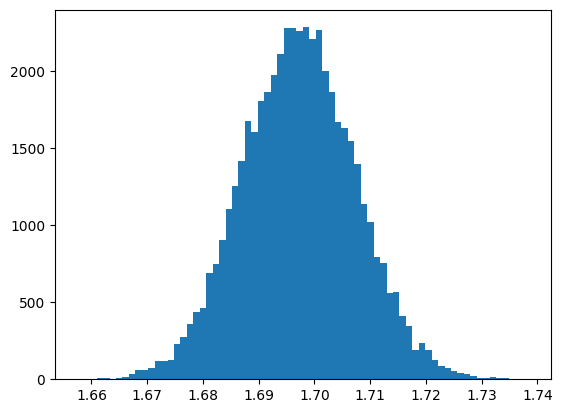

In [8]:
idx = red_priortable.index[(red_priortable.NODE == 'xsid_9') & (red_priortable.ENERGY == 5.)].to_numpy()
print(np.mean(chain.numpy()[:, idx]))
print(optres.position.numpy()[idx])
plt.hist(chain.numpy()[:,idx], bins=70)
plt.show()

In [9]:
#eval_mcmc_raw = np.mean(chain, axis=0)[:-num_covpars]
#eval_maxlike_raw = optres.position.numpy()[:-num_covpars]

eval_mcmc_raw = np.mean(chain, axis=0)
eval_maxlike_raw = optres.position.numpy()

In [10]:
prop_chain = np.zeros((chain.shape[0], len(outdt)), dtype=np.float64)
for idx in range(chain.shape[0]):
    curchain = chain[idx, :len(red_priortable)]
    prop_chain[idx, :] = restrmap_prop(curchain)

# calculate the mean values
eval_mcmc = np.mean(prop_chain, axis=0)
eval_mcmc_unc = np.std(prop_chain, axis=0)
eval_maxlike = restrmap_prop(optres.position[:len(red_priortable)]).numpy()

In [11]:
# some plotting
outdt['PRED_ML'] = eval_maxlike
outdt['PRED_MCMC'] = eval_mcmc
outdt['PRED_MCMC_UNC'] = eval_mcmc_unc
outdt['PRED_ML_vs_STD2017'] = eval_maxlike / outdt['DATA'] - 1.
outdt['PRED_MCMC_vs_STD2017'] = eval_mcmc / outdt['DATA'] - 1.

In [12]:
gmap_res = run_gmap_simplified(
    dbfile=gma_dbfile, dbtype=gma_dbtype,
    num_iter=4, remove_dummy=False
)
gmap_restable = gmap_res['table']
red_gmap_restable = gmap_restable[gmap_restable.NODE.str.match('xsid_|norm_')].reset_index(drop=True)
gmap_res0 = red_gmap_restable.POST.to_numpy(copy=True)
gmap_res = restrmap_prop(red_gmap_restable.POST.to_numpy())

/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


/home/gschnabel/Seafile/OmegaSpace/development/codeproj/gitrepos/gmapy/examples/standard_studies/std2017/../../../gmapy/data_management/specialized_datablock_apis/legacy_datablock_uncertainty_api.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  XYY = EPAF[1,L] - (E[KS]-E[KT])/(EPAF[2,L]*E[KS])


In [13]:
# hack for quick plotting
#gmap_res0 = eval_maxlike_raw
#gmap_res = restrmap_prop(eval_maxlike_raw)

In [14]:
outdt['GMAP'] = gmap_res
outdt['GMAP_vs_STD2017'] = gmap_res / outdt['DATA'] - 1
outdt['GMAP/STD2017'] = gmap_res / outdt['DATA']

In [15]:
# look at the thermal constants
selcrit = (outdt.DESCR.str.match('S.-') | 
    ((outdt.ENERGY == 2.53e-8) & outdt.DESCR.isin(('U5(n,f)', 'U8(n,f)', 'PU9(n,f)'))))
outdt['STD2017'] = outdt['DATA'].copy()
reldatacols = ['GMAP_vs_STD2017', 'PRED_ML_vs_STD2017', 'PRED_MCMC_vs_STD2017']
plotdt = outdt.loc[selcrit, ['DESCR', 'STD2017'] + reldatacols].copy()
for col in reldatacols:
    plotdt[col] = plotdt[col] * 100
plotdt = plotdt.sort_values('PRED_MCMC_vs_STD2017')
plotdt
# reminder: mention SS-PU1 case, mention SG-U3 case

DESCR  STD2017  GMAP_vs_STD2017  PRED_ML_vs_STD2017  \
158     SG-U3    44.90        -6.665624           -6.810395   
160     SG-U5    99.50        -0.233151           -0.323846   
165    SG-PU1   362.30        -0.138792           -0.164428   
282   U5(n,f)   587.30        -0.011846           -0.017243   
281   U5(n,f)   587.29        -0.010144           -0.015540   
412  PU9(n,f)   752.40        -0.009161           -0.017242   
413  PU9(n,f)   752.40        -0.009161           -0.017242   
164    SF-PU1  1023.60         0.024348            0.008332   
159     SS-U5    14.09         0.004480            0.056800   
162    SG-PU9   269.80         0.231987            0.222102   
157     SF-U3   533.00         0.282030            0.286735   
156     SS-U3    12.20         0.249826           -0.030666   
161    SS-PU9     7.80        -0.233752           -1.631741   
163    SS-PU1    11.90         0.235455           -3.962541   

     PRED_MCMC_vs_STD2017  
158             -6.368269  
160             -0.184764  
165             -0.078855  
282             -0.000805  
281              0.000898  
412              0.039981  
413              0.039981  
164              0.052286  
159              0.126158  
162              0.244840  
157              0.284576  
156              0.852167  
161              2.862503  
163             12.253115

In [16]:
outdt.columns

Index(['NODE', 'REAC', 'ENERGY', 'DATA', 'UNC', 'DESCR', 'PRED_ML',
       'PRED_MCMC', 'PRED_MCMC_UNC', 'PRED_ML_vs_STD2017',
       'PRED_MCMC_vs_STD2017', 'GMAP', 'GMAP_vs_STD2017', 'GMAP/STD2017',
       'STD2017'],
      dtype='object')

53173.08618187546


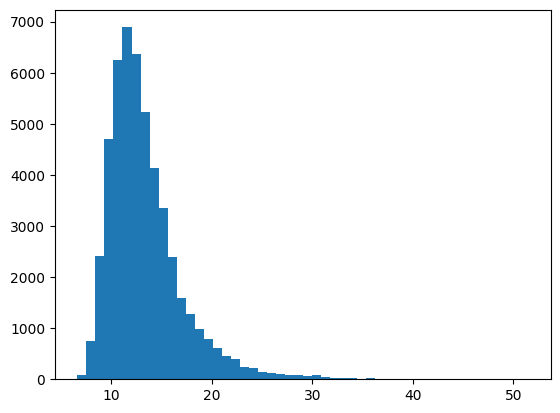

In [17]:
# explore the SS-PU1 case
# SS-PU1
selidx = outdt[(outdt.DESCR == 'SS-PU1')].index
curchain = prop_chain[:, selidx]
print(compute_effective_sample_size(curchain))
plt.hist(curchain, bins=50)
plt.show()

76714.64234352022


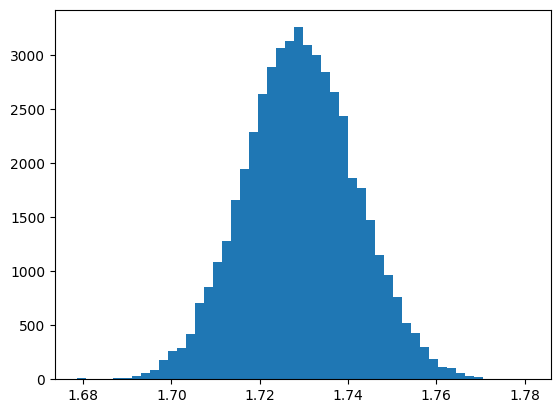

In [18]:
# SS-PU9
curchain = prop_chain[:, 479]
print(compute_effective_sample_size(curchain))
plt.hist(curchain, bins=50)
plt.show()

In [19]:
#np.where(curchain > 40)[0]
#testres = restrmap_prop(chain[10763, :])
#outdt['TESTRES'] = testres

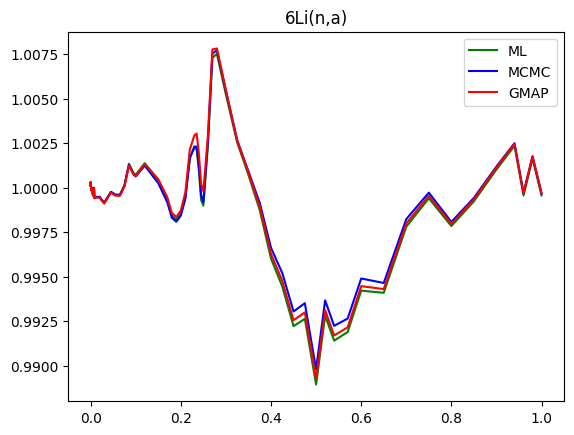

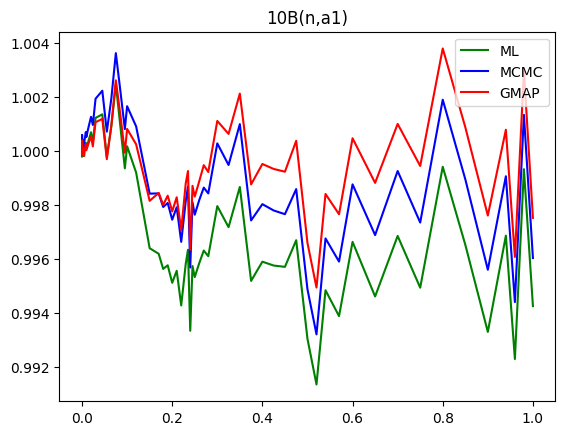

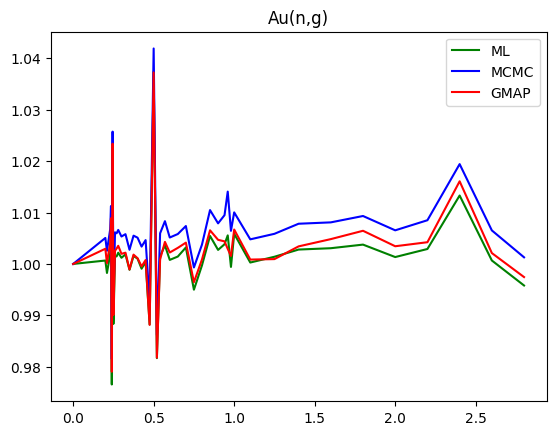

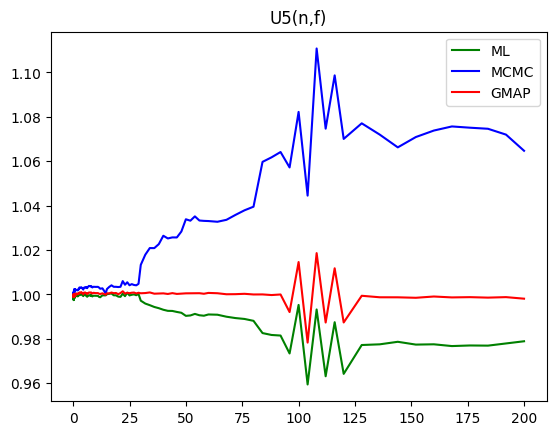

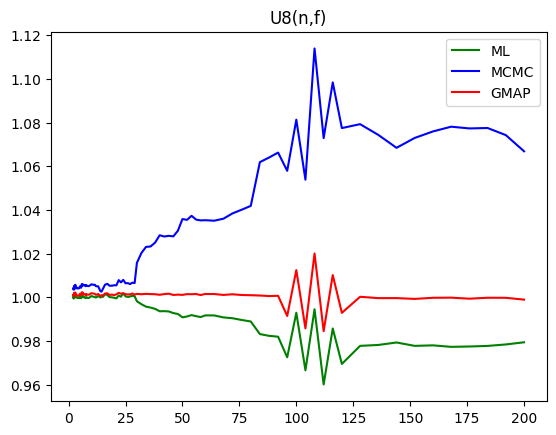

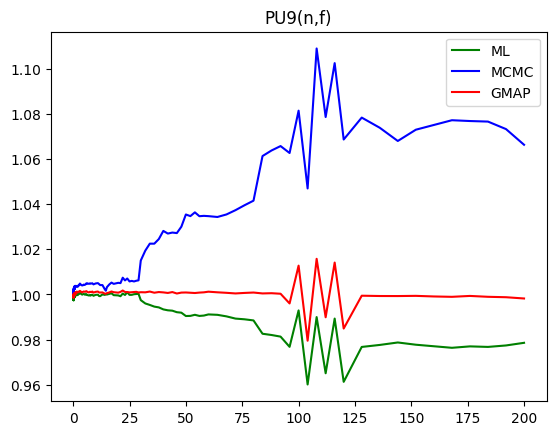

In [20]:
# show the energy-dependent quantities
for curdescr in descr_list:
    cdt = outdt[outdt.DESCR == curdescr]
    # plt.plot(cdt.ENERGY, cdt.PRED_ML)
    # plt.plot(cdt.ENERGY, cdt.PRED_MCMC)
    plt.plot(cdt.ENERGY, cdt.PRED_ML / cdt.DATA, color='green', label='ML')
    plt.plot(cdt.ENERGY, cdt.PRED_MCMC / cdt.DATA, color='blue', label='MCMC')
    plt.plot(cdt.ENERGY, cdt.GMAP / cdt.DATA, color='red', label='GMAP')
    # plt.plot(cdt.ENERGY, cdt.TESTRES / cdt.DATA, color='black', label='GMAP')
    # plt.axvline(x=30)
    plt.title(curdescr)
    plt.legend(loc='upper right')
    # plt.ylim(0.98, 1.01)
    plt.show()

In [21]:
outdt[outdt.DESCR=='U8(n,f)']

NODE        REAC  ENERGY   DATA  UNC    DESCR   PRED_ML  PRED_MCMC  \
70   exp_1005  MT:1-R1:10     2.0  0.538  1.3  U8(n,f)  0.537995   0.540154   
71   exp_1005  MT:1-R1:10     2.2  0.550  1.3  U8(n,f)  0.549659   0.551892   
72   exp_1005  MT:1-R1:10     2.4  0.547  1.3  U8(n,f)  0.547544   0.549817   
73   exp_1005  MT:1-R1:10     2.6  0.543  1.3  U8(n,f)  0.542826   0.544992   
74   exp_1005  MT:1-R1:10     2.8  0.539  1.4  U8(n,f)  0.539655   0.542025   
..        ...         ...     ...    ...  ...      ...       ...        ...   
151  exp_1005  MT:1-R1:10   168.0  1.282  4.7  U8(n,f)  1.252871   1.382101   
152  exp_1005  MT:1-R1:10   176.0  1.325  4.6  U8(n,f)  1.295103   1.427400   
153  exp_1005  MT:1-R1:10   184.0  1.328  4.9  U8(n,f)  1.298396   1.430887   
154  exp_1005  MT:1-R1:10   192.0  1.311  4.5  U8(n,f)  1.282649   1.408304   
155  exp_1005  MT:1-R1:10   200.0  1.319  4.4  U8(n,f)  1.291781   1.407140   

     PRED_MCMC_UNC  PRED_ML_vs_STD2017  PRED_MCMC_vs_STD2017      GMAP  \
70        0.003232           -0.000010              0.004005  0.538554   
71        0.003206           -0.000620              0.003441  0.550258   
72        0.003381            0.000994              0.005151  0.548067   
73        0.003387           -0.000321              0.003669  0.543359   
74        0.003609            0.001215              0.005612  0.540168   
..             ...                 ...                   ...       ...   
151       0.069782           -0.022721              0.078082  1.281751   
152       0.069251           -0.022564              0.077283  1.324111   
153       0.073092           -0.022292              0.077475  1.327682   
154       0.066408           -0.021626              0.074221  1.310650   
155       0.064979           -0.020636              0.066823  1.317548   

     GMAP_vs_STD2017  GMAP/STD2017  STD2017  
70          0.001030      1.001030    0.538  
71          0.000469      1.000469    0.550  
72          0.001950      1.001950    0.547  
73          0.000661      1.000661    0.543  
74          0.002168      1.002168    0.539  
..               ...           ...      ...  
151        -0.000194      0.999806    1.282  
152        -0.000671      0.999329    1.325  
153        -0.000239      0.999761    1.328  
154        -0.000267      0.999733    1.311  
155        -0.001101      0.998899    1.319  

[86 rows x 15 columns]

96491.33204899124
1.4083038141999327


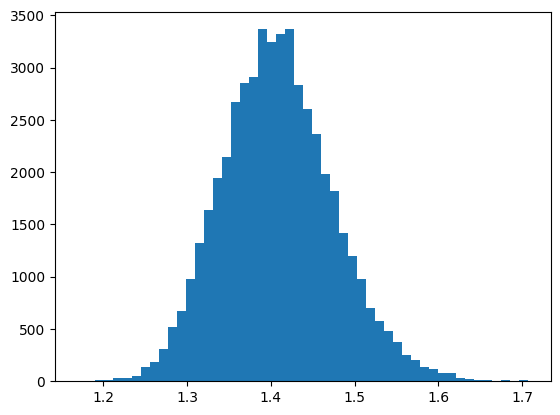

In [22]:
# U8(n,f) at 192 MeV
selidx = outdt[(outdt.DESCR == 'U8(n,f)') & (outdt.ENERGY==192.)].index
curchain = prop_chain[:, selidx]
print(compute_effective_sample_size(curchain))
print(np.mean(curchain))
plt.hist(curchain, bins=50)
plt.show()

In [68]:
selidx = outdt[(outdt.DESCR.isin(('PU9(n,f)', 'U8(n,f)'))) & (outdt.ENERGY==192.)].index
curchain = prop_chain[:, selidx]
df = pd.DataFrame({'xs1': curchain[:, 0], 'xs2': curchain[:,1]})

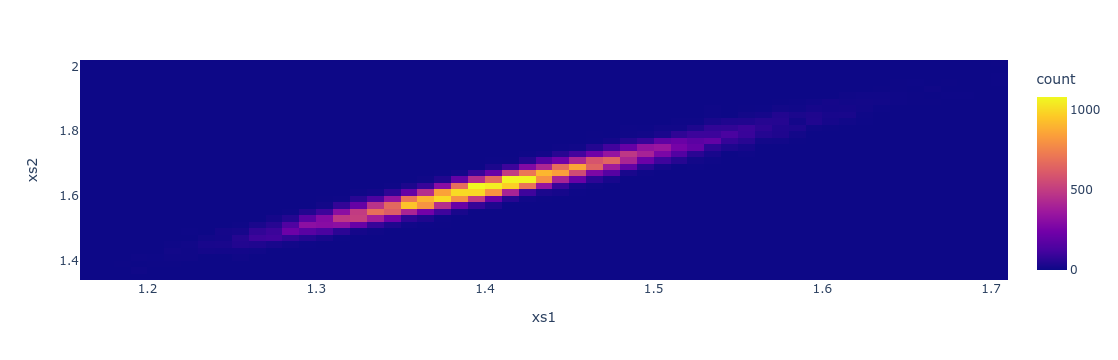

In [69]:
import plotly.express as px
fig = px.density_heatmap(df, x="xs1", y="xs2")
fig.show()

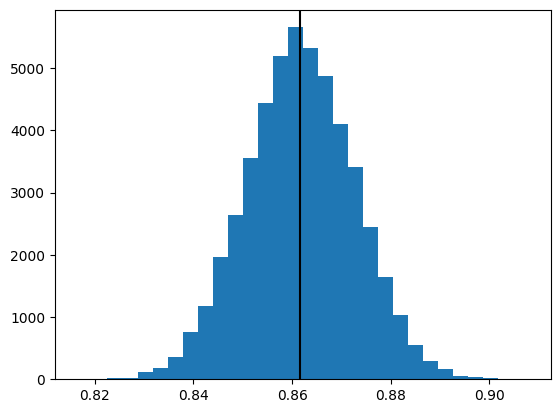

In [74]:
plt.hist(curchain[:, 0] / curchain[:, 1], bins=30)
plt.axvline(x=np.mean(curchain[:, 0] / curchain[:, 1]), color='black')
plt.show()

In [86]:
# show what type of data we that refers to U5(n,f) 
exp_with_U5 = exptable[exptable.REAC.str.match('.*-R.:8')]
# exp_with_U5 = exptable[exptable.REAC.str.match('MT:3-R1:9-R2:8')]
# exp_with_U5 = exptable[exptable.REAC.str.match('MT:2-R1:8')]
result = exp_with_U5.groupby(['NODE', 'REAC']).agg(MinEn=('ENERGY', np.min), MaxEn=('ENERGY', np.max), NumPts=('ENERGY', len))
result = result.sort_values('MaxEn')
result[result.MaxEn >= 29.]

MinEn  MaxEn  NumPts
NODE     REAC                                    
exp_524  MT:2-R1:8         2.40000   30.0      37
exp_824  MT:4-R1:10-R2:8   1.40000   30.0      46
exp_600  MT:3-R1:9-R2:8    0.00085   30.0      86
exp_805  MT:3-R1:10-R2:8   0.54000   34.0      61
exp_1014 MT:3-R1:9-R2:8    0.85000   60.0      72
exp_1003 MT:2-R1:8        40.00000   68.0      13
exp_8015 MT:3-R1:10-R2:8   0.54000  192.0      50
exp_8016 MT:3-R1:10-R2:8   0.52000  192.0      62
exp_8017 MT:3-R1:10-R2:8   1.00000  192.0      55
exp_8018 MT:3-R1:10-R2:8   1.10000  192.0      54
exp_8030 MT:3-R1:10-R2:8   0.80000  200.0      97
exp_1030 MT:3-R1:10-R2:8   0.85000  200.0      96
exp_1029 MT:3-R1:9-R2:8    0.50000  200.0     105
exp_1028 MT:2-R1:8         3.00000  200.0      81
exp_1013 MT:3-R1:10-R2:8   0.57000  200.0      94
exp_1012 MT:3-R1:9-R2:8    0.57000  200.0      94
exp_8007 MT:3-R1:10-R2:8  34.00000  200.0       7

In [108]:
# prepare data renormalization factors
exptable['RENORM_DATA_ML'] = exptable['DATA'].copy()
exptable['RENORM_DATA_MCMC'] = exptable['DATA'].copy()
normdt = gmap_restable[gmap_restable.NODE.str.startswith('norm_')]
normdt = red_priortable[red_priortable.NODE.str.startswith('norm_')].copy()
# for MCMC result
rescale_vec_mcmc = np.mean(chain, axis=0)[normdt.index]
normdt['POST_MCMC'] = rescale_vec_mcmc
# for maxlike result
rescale_vec_ml = optres.position.numpy()[normdt.index]
normdt['POST_ML'] = rescale_vec_ml

In [113]:
# calculate renormalized data
for idx, row in normdt.iterrows():
    expid = row.NODE[5:]
    expname = 'exp_' + str(expid)
    if not (exptable.NODE == expname).any():
        raise ValueError()
    sel = exptable.NODE==expname
    exptable.loc[sel, 'RENORM_DATA_ML'] = exptable.loc[sel, 'DATA'] / row['POST_ML']
    exptable.loc[sel, 'RENORM_DATA_MCMC'] = exptable.loc[sel, 'DATA'] / row['POST_MCMC']

In [117]:
grouped = exptable.groupby('ABSREAC')
energies = priortable.loc[(priortable.NODE == 'xsid_1'), 'ENERGY'].to_numpy()
dflist = []
count = 2000
for idx, group in grouped:
    count += 1
    curnode = f'exp_{count}'
    #curenergies = priortable.loc[priortable.REAC == idx, 'ENERGY'].to_numpy()
    #curenergies = curenergies[(curenergies >= group.ENERGY.min()) & (curenergies <= group.ENERGY.max())]
    curenergies = energies
    dflist.append(pd.DataFrame({'NODE': curnode, 'REAC': idx, 'ENERGY': curenergies}))
outdt2 = pd.concat(dflist)
compmap2 = CompoundMap((priortable, outdt2), reduce=True)

restrmap2 = RestrictedMap(len(is_adj), compmap2.propagate, compmap2.jacobian,
    fixed_params=priortable.loc[~is_adj, 'PRIOR'].to_numpy(copy=True),
    fixed_params_idcs=np.where(~is_adj)[0]
)
restrmap_prop2 = tf.function(restrmap2.propagate)
outdt2['PRED_ML'] = restrmap_prop2(eval_maxlike_raw)
outdt2['PRED_MCMC'] = restrmap_prop2(eval_mcmc_raw)
outdt2['GMAP'] = restrmap_prop2(gmap_res0)

tmp = np.zeros((len(outdt2), chain.shape[0]), dtype=np.float64)
for i in range(chain.shape[0]):
    tmp[:, i] = restrmap_prop2(chain[i, :])
eval_mcmc_nonlinear = np.mean(tmp, axis=1)
outdt2['PRED_MCMC2'] = eval_mcmc_nonlinear

In [118]:
outdt2

NODE                 REAC        ENERGY     PRED_ML   PRED_MCMC  \
0   exp_2001            MT:1-R1:1  2.530000e-08  938.145612  938.129798   
1   exp_2001            MT:1-R1:1  9.400000e-06   48.640463   48.639640   
2   exp_2001            MT:1-R1:1  1.500000e-04   12.160891   12.160775   
3   exp_2001            MT:1-R1:1  2.500000e-04    9.413169    9.413068   
4   exp_2001            MT:1-R1:1  3.500000e-04    7.952047    7.951958   
..       ...                  ...           ...         ...         ...   
75  exp_2065  MT:7-R1:9-R2:3-R3:4  2.000000e+00         inf         inf   
76  exp_2065  MT:7-R1:9-R2:3-R3:4  2.200000e+00         inf         inf   
77  exp_2065  MT:7-R1:9-R2:3-R3:4  2.400000e+00         inf         inf   
78  exp_2065  MT:7-R1:9-R2:3-R3:4  2.600000e+00         inf         inf   
79  exp_2065  MT:7-R1:9-R2:3-R3:4  2.800000e+00         inf         inf   

          GMAP  PRED_MCMC2  
0   938.130787  938.129798  
1    48.639676   48.639640  
2    12.160769   12.160775  
3     9.413052    9.413068  
4     7.951947    7.951958  
..         ...         ...  
75         inf         inf  
76         inf         inf  
77         inf         inf  
78         inf         inf  
79         inf         inf  

[5200 rows x 7 columns]

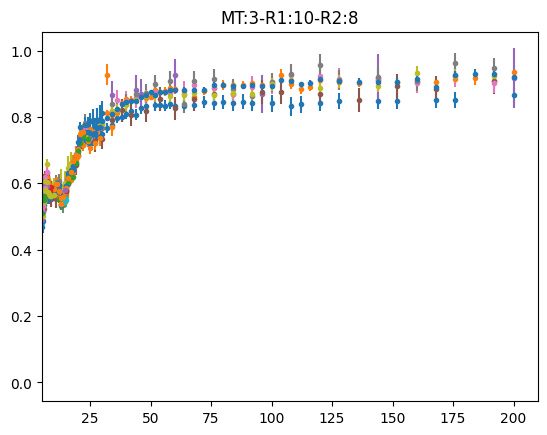

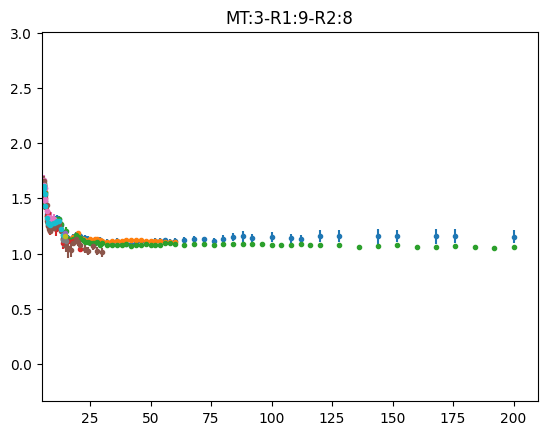

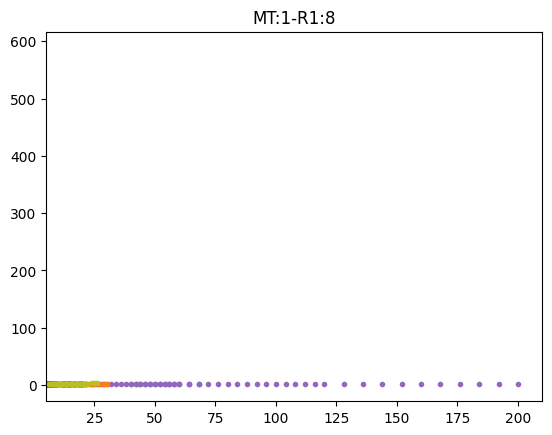

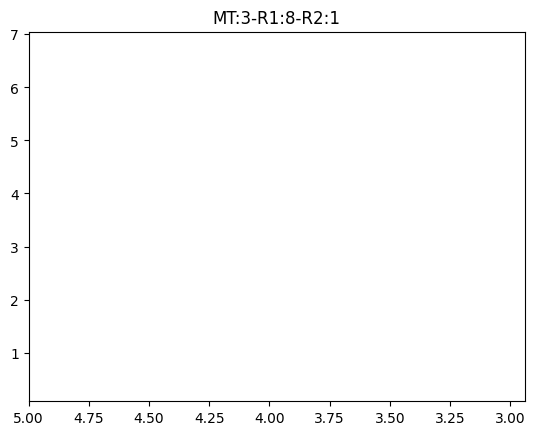

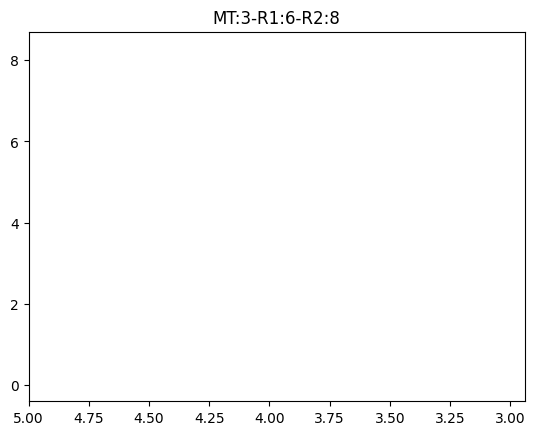

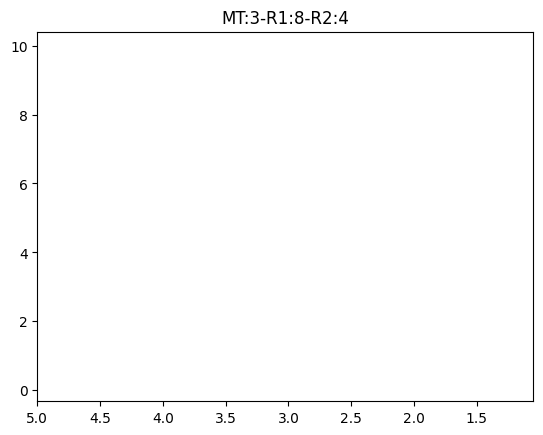

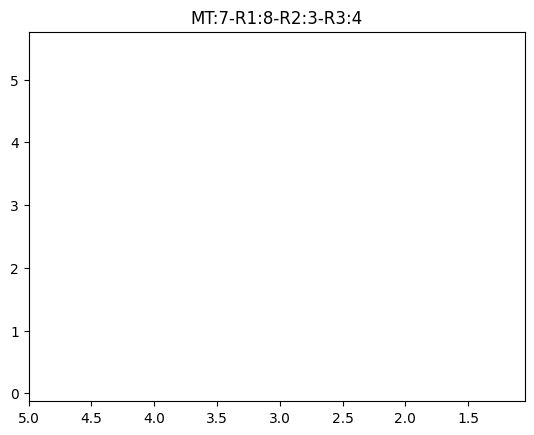

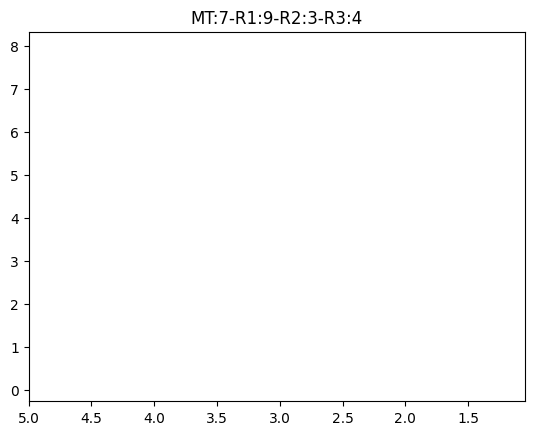

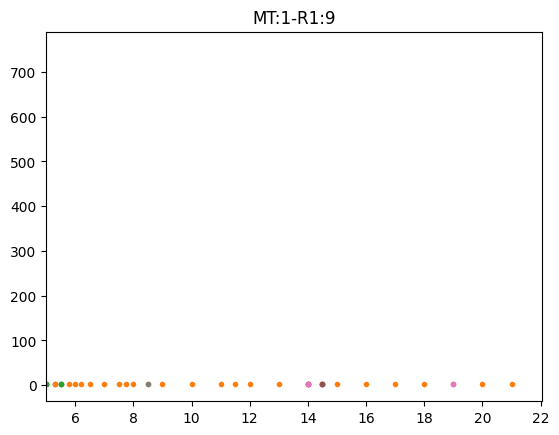

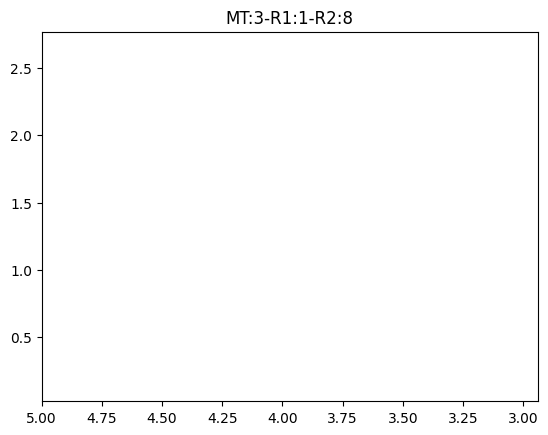

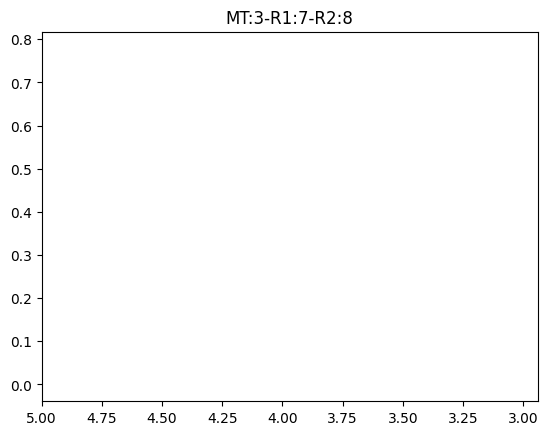

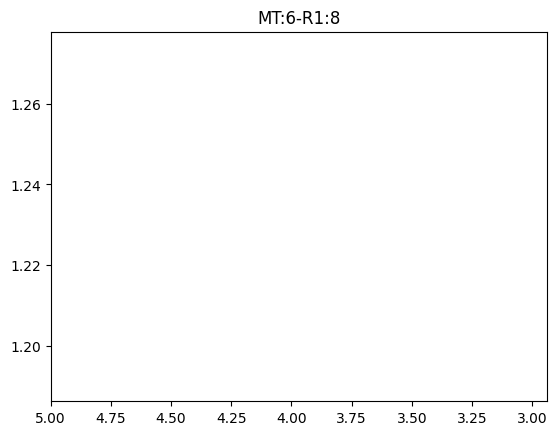

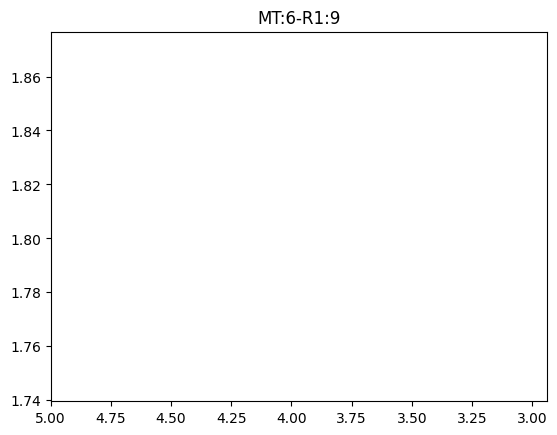

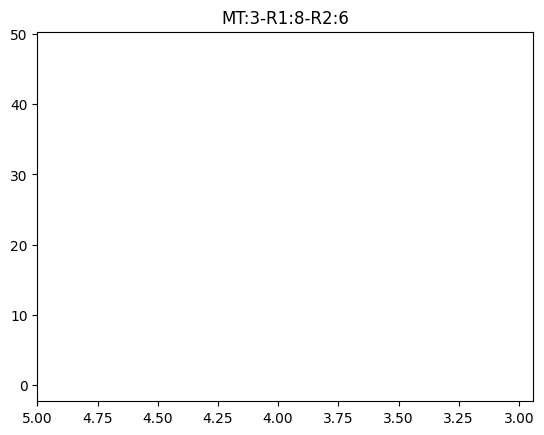

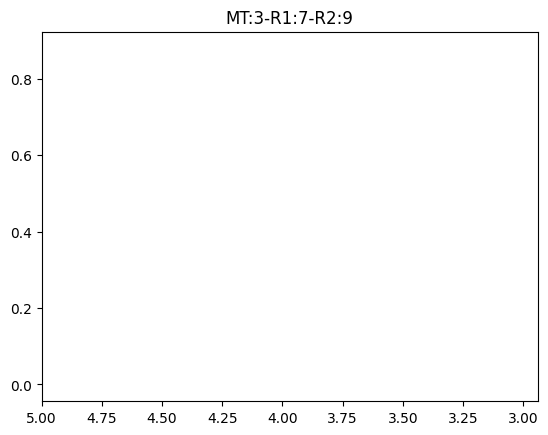

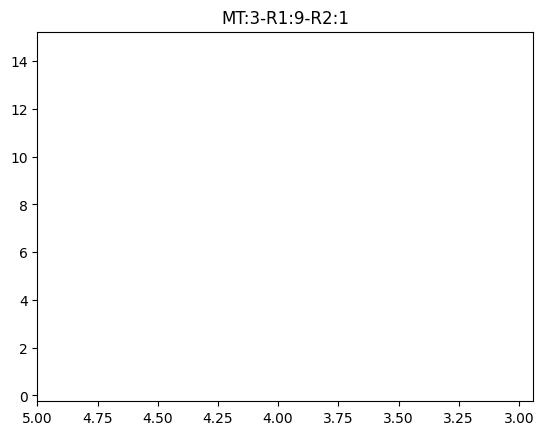

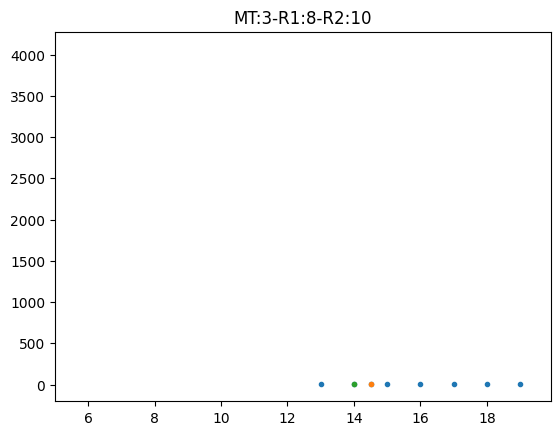

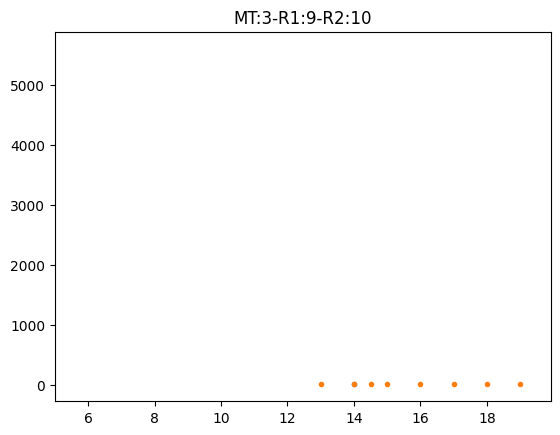

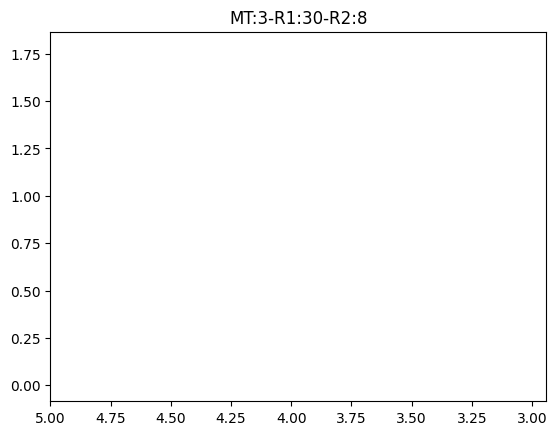

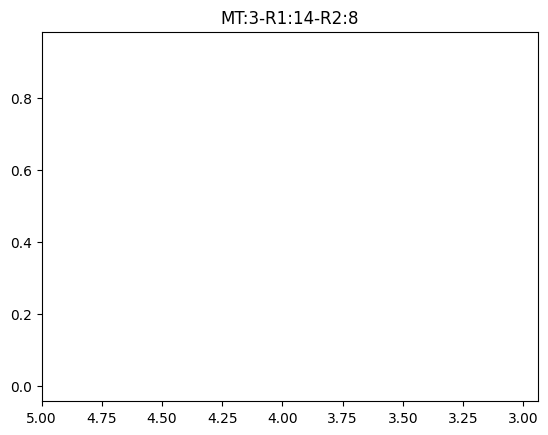

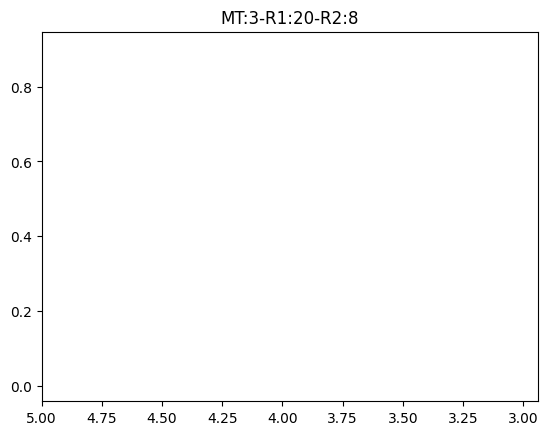

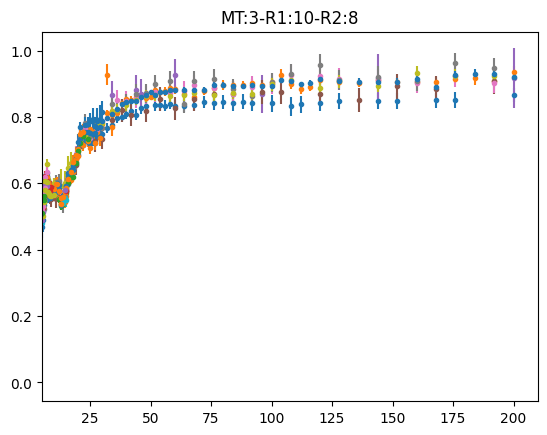

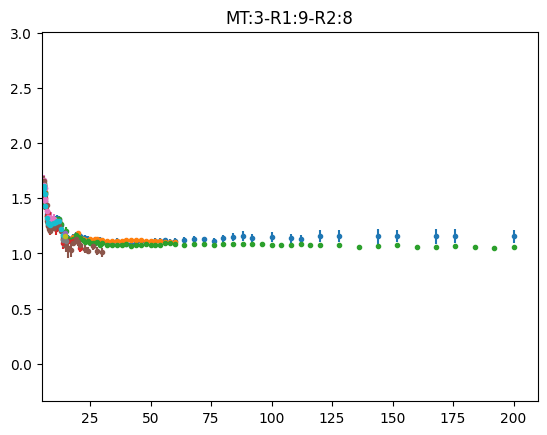

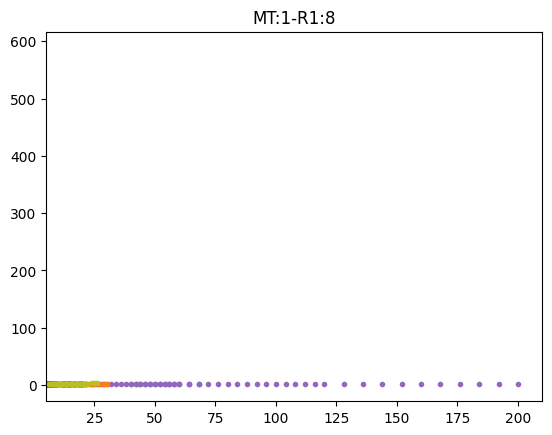

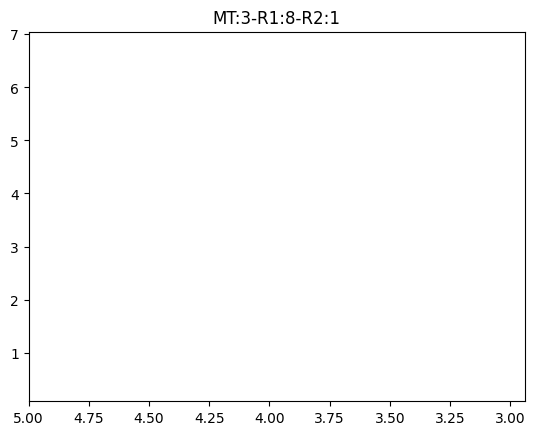

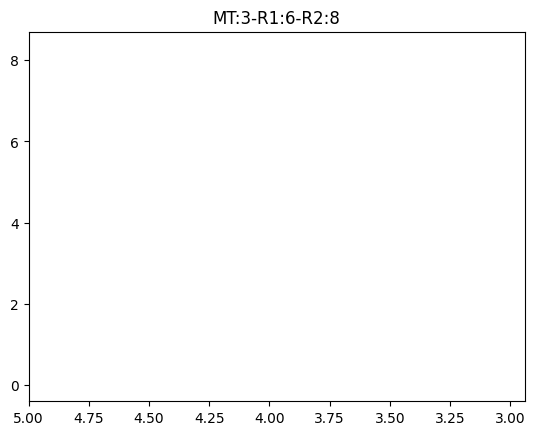

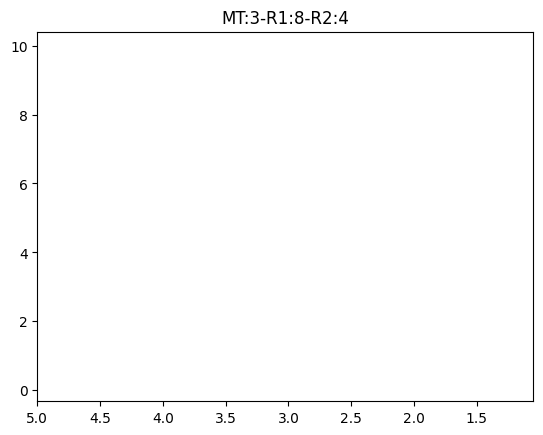

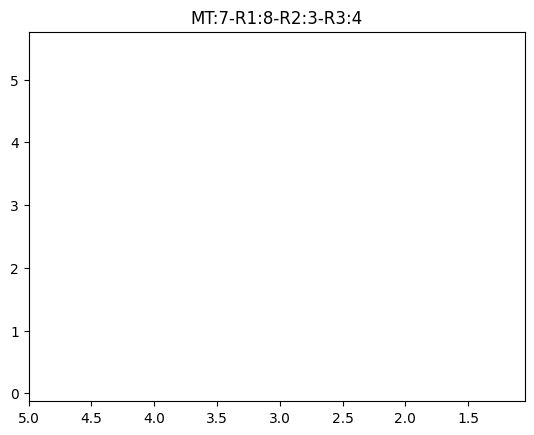

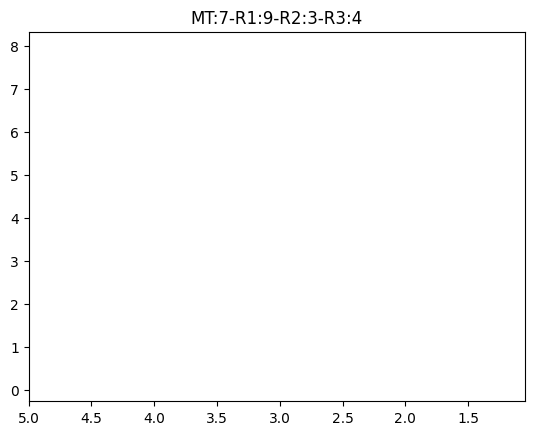

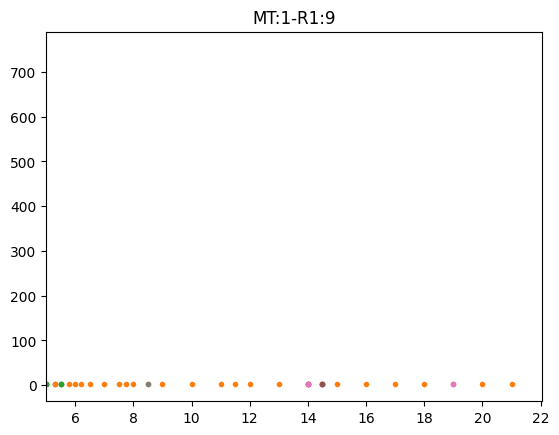

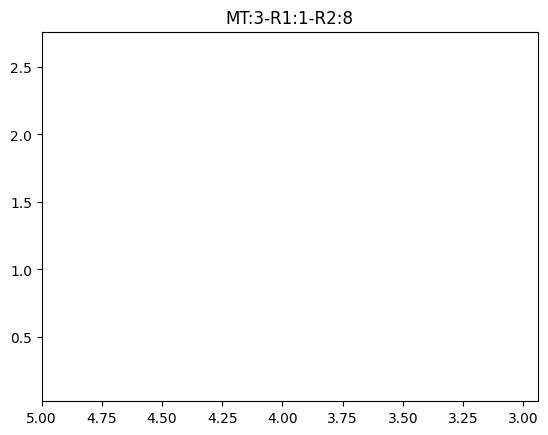

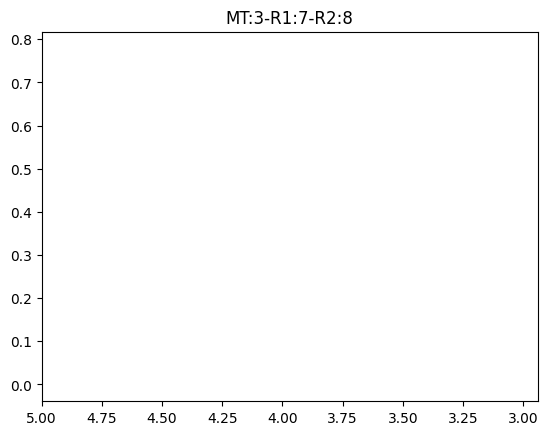

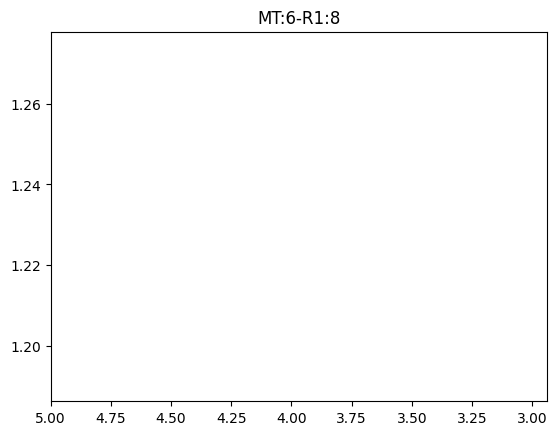

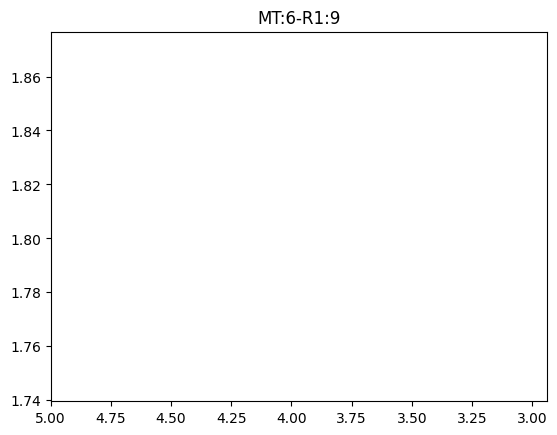

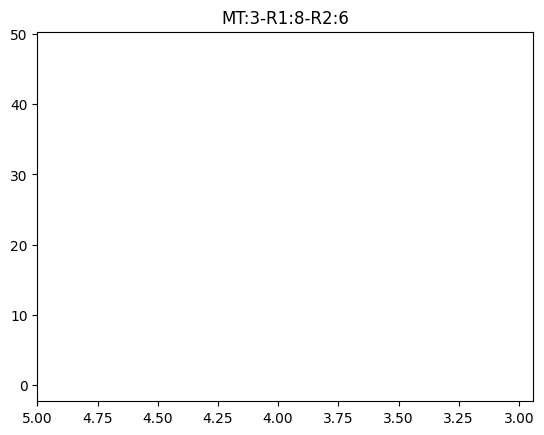

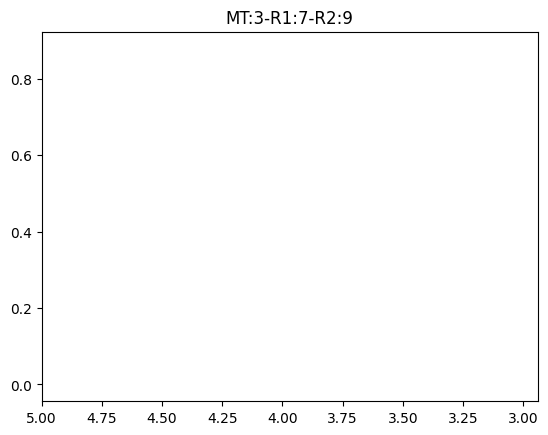

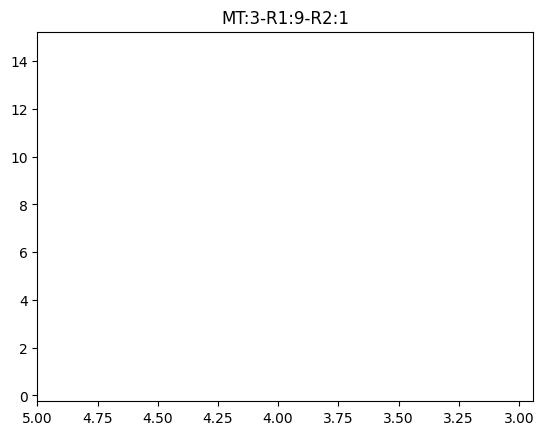

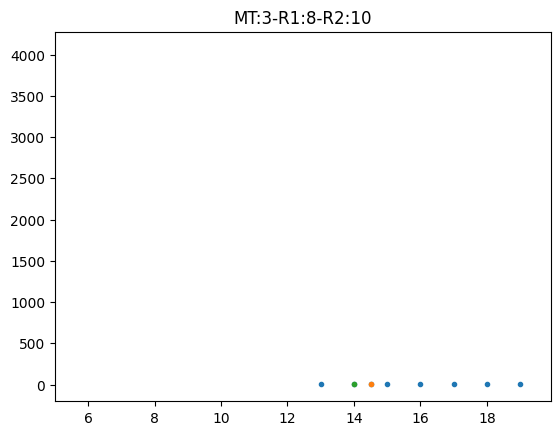

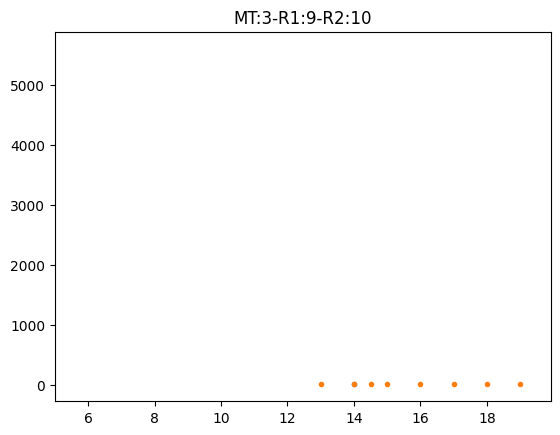

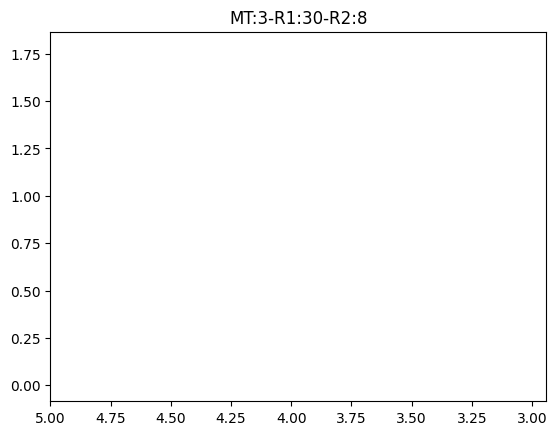

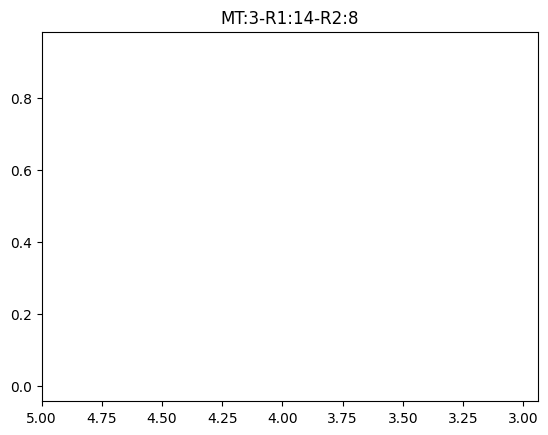

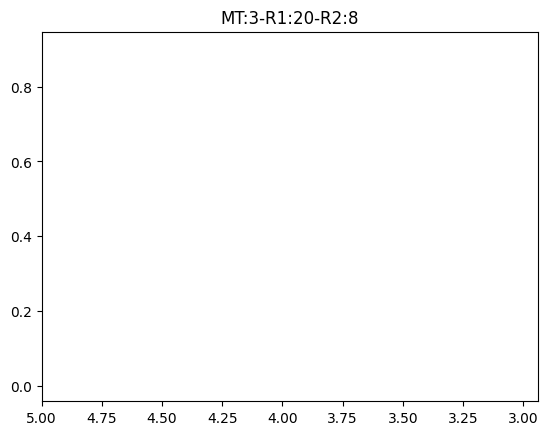

In [119]:
# select the column that the contains the posterior to be used for renormalization
for renorm_col in ('RENORM_DATA_ML', 'RENORM_DATA_MCMC'):
    #renorm_col = 'RENORM_DATA_ML'

    # for curreac in ('MT:1-R1:8', 'MT:1-R1:9'):
    for curreac in exptable.loc[exptable.ABSREAC.str.match('.*-R.:[89]'), 'ABSREAC'].unique():
        # curreac = 'MT:1-R1:8'
        #curreac = 'MT:2-R1:8'
        #curreac = 'MT:3-R1:9-R2:8'
        #curreac = 'MT:3-R1:10-R2:8'
        rtbl = exptable[(exptable.ABSREAC==curreac) & (exptable.ENERGY > 0)]
        grouped = rtbl.groupby('NODE')
        for gname, gdata in grouped:
            # plt.scatter(gdata['ENERGY'], gdata['RENORM_DATA'], s=5)
            plt.errorbar(gdata['ENERGY'], gdata[renorm_col], yerr=gdata['UNC'],
                    fmt='o', markersize=3, label=gdata['NODE'].iloc[0])
            tmp = outdt2[(outdt2.REAC == gdata['ABSREAC'].iloc[0]) & (outdt2.ENERGY > 0)]
            #plt.plot(tmp.ENERGY, tmp.PRED_MCMC2, color='black', lw=0.2)
            plt.plot(tmp.ENERGY, tmp.PRED_MCMC, color='black', lw=0.2)
            plt.plot(tmp.ENERGY, tmp.PRED_ML, color='blue', linestyle='--', lw=0.2)
            # plt.plot(tmp.ENERGY, tmp.GMAP, color='brown', linestyle='--', lw=0.2)
            # plt.plot(tmp.ENERGY, tmp.PRED_MCMC / tmp.PRED_ML, color='black', linestyle='--', lw=0.2)
        
        # plt.legend(loc='upper right')
        #plt.xlim(0,150)
        #plt.xlim(0, 10)
        #plt.ylim(1, 3)
        plt.xlim(5, None)
        plt.title(curreac)
        plt.show()

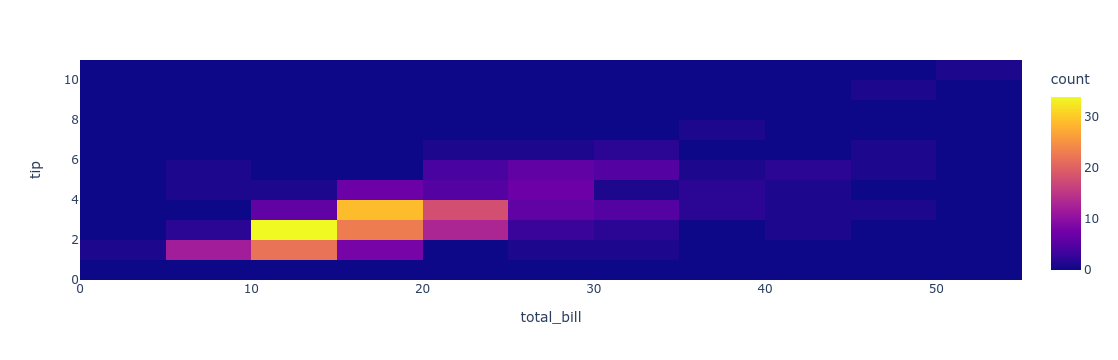

In [32]:
import plotly.express as px
df = px.data.tips()

fig = px.density_heatmap(df, x="total_bill", y="tip")
fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


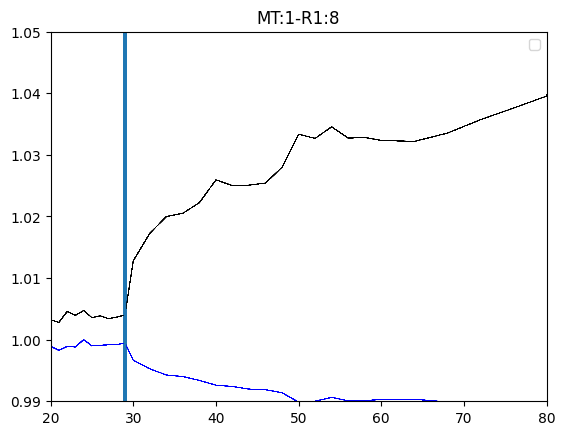

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


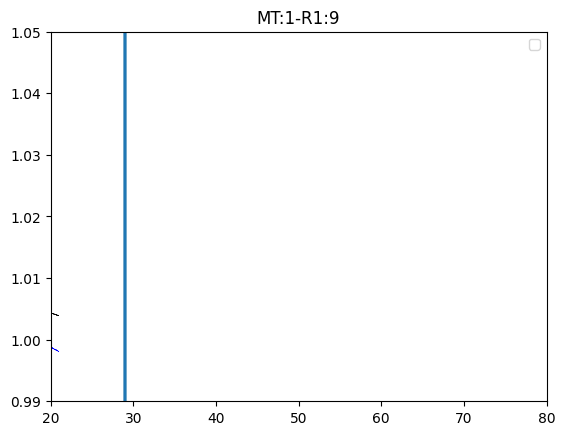

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


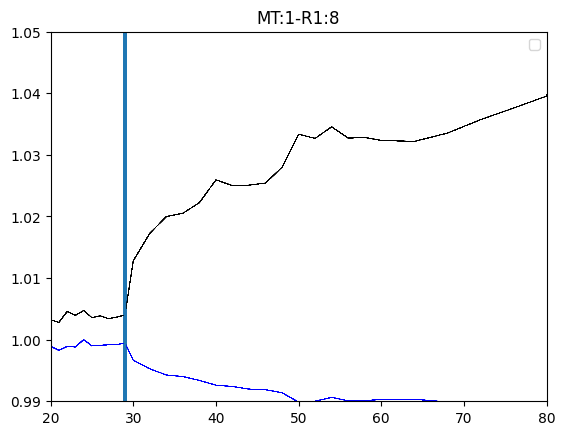

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


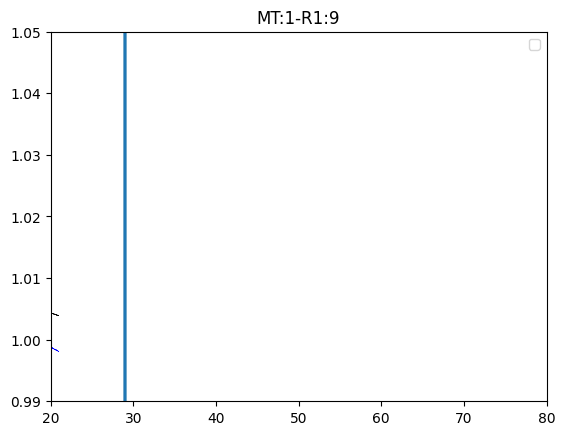

In [83]:
# select the column that the contains the posterior to be used for renormalization
for renorm_col in ('RENORM_DATA_ML', 'RENORM_DATA_MCMC'):
    #renorm_col = 'RENORM_DATA_ML'

    for curreac in ('MT:1-R1:8', 'MT:1-R1:9'):
        #curreac = 'MT:1-R1:8'
        #curreac = 'MT:2-R1:8'
        #curreac = 'MT:3-R1:9-R2:8'
        #curreac = t'MT:3-R1:10-R2:8'
        rtbl = exptable[(exptable.ABSREAC==curreac) & (exptable.ENERGY > 0)]
        grouped = rtbl.groupby('NODE')
        for gname, gdata in grouped:
            # plt.scatter(gdata['ENERGY'], gdata['RENORM_DATA'], s=5)
            # plt.errorbar(gdata['ENERGY'], gdata[renorm_col], yerr=gdata['UNC'],
            #        fmt='o', markersize=3, label=gdata['NODE'].iloc[0])
            tmp = outdt2[(outdt2.REAC == gdata['ABSREAC'].iloc[0]) & (outdt2.ENERGY > 0)]
            #plt.plot(tmp.ENERGY, tmp.PRED_MCMC2, color='black', lw=0.2)
            #plt.plot(tmp.ENERGY, tmp.PRED_MCMC, color='black', lw=0.2)
            # plt.plot(tmp.ENERGY, tmp.PRED_ML, color='blue', linestyle='dashed', lw=0.2)
            plt.plot(tmp.ENERGY, tmp.PRED_MCMC / tmp.GMAP, color='black', linestyle='--', lw=0.2)
            plt.plot(tmp.ENERGY, tmp.PRED_ML / tmp.GMAP, color='blue', linestyle='--', lw=0.2)
            plt.axvline(x=29)
        
        plt.legend(loc='upper right')
        # plt.xlim(0,150)
        plt.xlim(20, 80)
        
        plt.ylim(0.99, 1.05)
        # plt.ylim(1, 3)
        plt.title(curreac)
        plt.show()

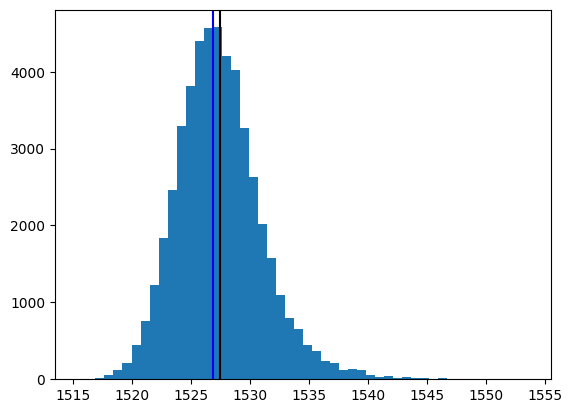

0.00038002609878546564

In [35]:
# marginal distribution along a non-axis direction
d = eval_mcmc_raw - eval_maxlike_raw
d = d / np.sqrt(np.sum(d**2))
project_chain = np.squeeze(chain.numpy() @ d.reshape(-1, 1))
# get mean and mode
tmp_mean = np.mean(project_chain)
hist, bin_edges = np.histogram(project_chain, bins=70)
tmp_mode = bin_edges[np.argmax(hist)]
# plot the histogram
hist = plt.hist(project_chain, bins=50)
plt.axvline(x=np.mean(project_chain), color='black')
plt.axvline(x=tmp_mode, color='blue')
plt.show()
# difference of expectation versus mean
(tmp_mean - tmp_mode) / tmp_mean 

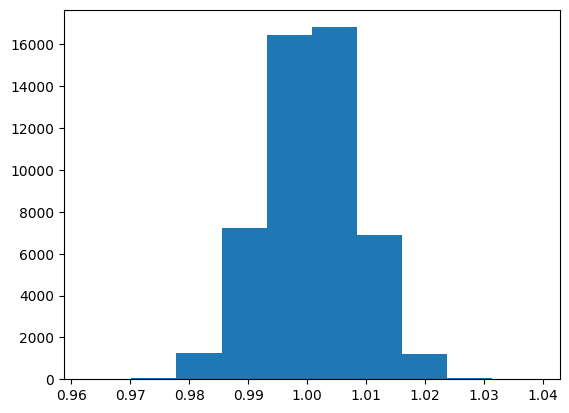

In [36]:
#import plotly.express as px
#fig = px.scatter(rtbl, x='ENERGY', y='DATA', color='NODE')
#fig.show()
idx1 = red_priortable[red_priortable.NODE=='norm_1028'].index
exptable[exptable.NODE=='exp_1028']
plt.hist(chain.numpy()[:, idx1])
plt.show()

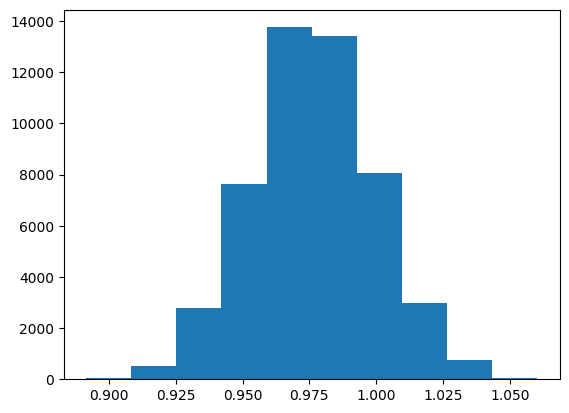

In [37]:
idx2 = red_priortable[red_priortable.NODE=='norm_1003'].index
plt.hist(chain.numpy()[:, idx2])
plt.show()

In [45]:
# show the difference of the normalization factor
idx1 = red_priortable[red_priortable.NODE=='norm_1028'].index
print(f'norm_1028 (maxlike): {np.squeeze(optres.position.numpy()[idx1])}')
print(f'norm_1028 (mcmc): {np.mean(chain.numpy()[:, idx1])}')

idx2 = red_priortable[red_priortable.NODE=='norm_1003'].index
print(f'norm_1003 (maxlike): {np.squeeze(optres.position.numpy()[idx2])}')
print(f'norm_1003 (mcmc): {np.mean(chain.numpy()[:, idx2])}')

norm_1028 (maxlike): 0.9879752343991702
norm_1028 (mcmc): 1.0006943111111488
norm_1003 (maxlike): 1.0112867628582178
norm_1003 (mcmc): 0.9764489828880336


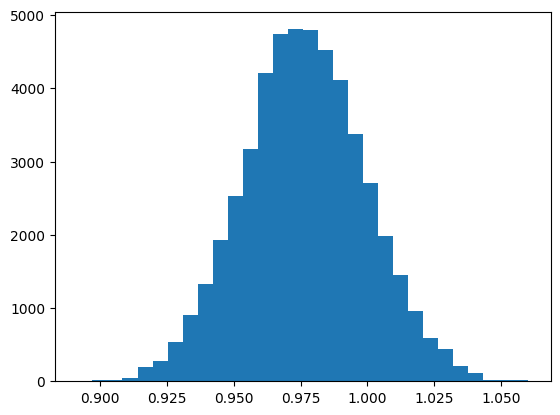

In [44]:
plt.hist(chain.numpy()[:,idx2], bins=30)
plt.show()

In [39]:
# here for the SACS
sacs_descrs = ('SACS U5(n,f)', 'SACS PU9(n,f)', 'SACS PU9/U5')
sacs_reacs = ('MT:6-R1:8', 'MT:6-R1:9', 'MT:10-R1:9-R2:8')
sacs_dtlist = []
sacs_cnt = 0
for q, descr in zip(sacs_reacs, sacs_descrs):
    sacs_cnt += 1
    sacs_dtlist.append(pd.DataFrame({
        'NODE': 'exp_' + str(sacs_cnt), 'REAC': [q],
        'ENERGY': 2.53e-8, 'DATA': 0,
        'UNC': 0, 'DESCR': descr
    }))
sacs_dt = pd.concat(sacs_dtlist, ignore_index=True)
sacs_dt

NODE             REAC        ENERGY  DATA  UNC          DESCR
0  exp_1        MT:6-R1:8  2.530000e-08     0    0   SACS U5(n,f)
1  exp_2        MT:6-R1:9  2.530000e-08     0    0  SACS PU9(n,f)
2  exp_3  MT:10-R1:9-R2:8  2.530000e-08     0    0    SACS PU9/U5

In [40]:
# create the mapping object
sacsmap = CompoundMap((priortable, sacs_dt), reduce=True)
restrsacsmap = RestrictedMap(len(is_adj), sacsmap.propagate, sacsmap.jacobian,
        fixed_params=priortable.loc[~is_adj, 'PRIOR'].to_numpy(copy=True),
        fixed_params_idcs=np.where(~is_adj)[0]
)
restrmap_prop = tf.function(restrsacsmap.propagate)

In [41]:
print('SACS U5(n,f), SACS PU9(n,f), SACS PU9 / U5')
print(f'MCMC: {restrmap_prop(eval_mcmc_raw).numpy()}')
print(f'MLE: {restrmap_prop(eval_maxlike_raw).numpy()}')
print(f'GMAP: {restrmap_prop(gmap_res0).numpy()}')

SACS U5(n,f), SACS PU9(n,f), SACS PU9 / U5
MCMC: [1.22765877 1.80758478 1.47238372]
MLE: [1.22420962 1.80065303 1.47086986]
GMAP: [1.22527688 1.80250048 1.47109647]


## Exploration of discrepancy between MCMC and MLE



In [48]:
from gmapy.tf_uq.inference import determine_MAP_estimate

In [47]:
post, = load_objects(thisdir + '01_model_preparation_output.pkl', 'post')

In [54]:
neg_log_prob_and_gradient = tf.function(post.neg_log_prob_and_gradient)
neg_log_post_hessian = post.neg_log_prob_hessian

In [55]:
optres = determine_MAP_estimate(
    eval_mcmc_raw, neg_log_prob_and_gradient, neg_log_post_hessian,
    max_inner_iters=500, max_outer_iters=50, nugget=1e-4,
    ret_optres=True, must_converge=True
)

#  outer iteration 1
-- running inner iteration with 500 iterations
Inner iterations: 394


In [66]:
np.max((np.abs(optres.position.numpy() - eval_maxlike_raw) / np.abs(optres.position.numpy())))

0.00019135326806220488

## Explore further visually the discrepancy between MCMC and MLE

In [77]:
red_priortable.ENERGY.unique()

array([2.53e-08, 9.40e-06, 1.50e-04, 2.50e-04, 3.50e-04, 4.50e-04,
       5.50e-04, 6.50e-04, 7.50e-04, 8.50e-04, 9.50e-04, 1.50e-03,
       2.50e-03, 3.50e-03, 4.50e-03, 5.50e-03, 6.50e-03, 7.50e-03,
       8.50e-03, 9.50e-03, 1.50e-02, 2.00e-02, 2.40e-02, 3.00e-02,
       4.50e-02, 5.50e-02, 6.50e-02, 7.50e-02, 8.50e-02, 9.50e-02,
       1.00e-01, 1.20e-01, 1.50e-01, 1.70e-01, 1.80e-01, 1.90e-01,
       2.00e-01, 2.10e-01, 2.20e-01, 2.30e-01, 2.35e-01, 2.40e-01,
       2.45e-01, 2.50e-01, 2.60e-01, 2.70e-01, 2.80e-01, 3.00e-01,
       3.25e-01, 3.50e-01, 3.75e-01, 4.00e-01, 4.25e-01, 4.50e-01,
       4.75e-01, 5.00e-01, 5.20e-01, 5.40e-01, 5.70e-01, 6.00e-01,
       6.50e-01, 7.00e-01, 7.50e-01, 8.00e-01, 8.50e-01, 9.00e-01,
       9.40e-01, 9.60e-01, 9.80e-01, 1.00e+00, 1.10e+00, 1.25e+00,
       1.40e+00, 1.60e+00, 1.80e+00, 2.00e+00, 2.20e+00, 2.40e+00,
       2.60e+00, 2.80e+00, 3.00e+00, 3.60e+00, 4.00e+00, 4.50e+00,
       4.70e+00, 5.00e+00, 5.30e+00, 5.50e+00, 5.80e+00, 6.00e